# **Лабораторна робота №4**
### з дисципліни **"Інтелектуальні системи підтримки прийняття рішень"**

##### **За темою:** "Навчання регресiйної моделi градiєнтними методами в TensorFlow"

##### **Варіант:** 17

##### **Виконав:** Гавлицький Іван, КА-12

##### **Перевірила:** Недашкiвська Н.I.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt 
import seaborn as sns

import time
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### **Мета роботи:**
* Навчитися створювати моделi згорткових нейронних мереж за допомогою бiблiотеки TensorFlow та API Keras.
* Використати згорткову нейронну мережу для класифiкацiї чорно-бiлих та кольорових зображень.
* Порiвняти результати з результатами на основi моделi MLP.
* Для представлення результатiв використати TensorBoard.

### **Хід виконання роботи:**
1. Завантажити два набори зображень згiдно з варiантом: чорно-бiлi (дивiться попереднiй практикум) та кольоровi. Якщо набiр великого розмiру, можна обрати частину.
1. Пiдготувати данi для навчання - за необхiдностi.
1. Роздiлити данi на навчальну, перевiрочну i тестову пiдмножини.
1. Побудувати i навчити базову модель з одним згортковим шаром. Оцiнити правильнiсть (accuracy) та точнiсть моделi на тренувальнiй i перевiрочнiй множинах.
1. Дослiдити рiзнi значення параметрiв padding i strides згорткового шару базової моделi, а також розмiрнiсть ядра (kernel) згортки та їх вплив на точнiсть моделi. На перевiрочнiй множинi обрати значення вказаних параметрiв.
1. Дослiдити кiлька альтернативних архiтектур згорткових моделей, якi включають:
    * кiлька згорткових шарiв,
    * шар/ шари нормалiзацiї за мiнi-батчами,
    * шар/ шари дропауту.

    На перевiрочнiй множинi оцiнити якiсть побудованих моделей i обрати найкращу архiтектуру. Використати показники якостi: accuracy, precision, recall, f1-score, AUC.

7. Чи впливає на правильнiсть (accuracy) моделi додавання регуляризацiї: дропаут, рання зупинка навчання, та використання рiзних методiв iнiцiалiзацiї ваг?
8. Вiдобразити у TensorBoard графiки, якi iлюструють оцiнки якостi навчання мереж на навчальнiй та перевiрочнiй множинах:
    * графiки змiни функцiї втрат на тренувальнiй i перевiрочнiй множинах по мiрi навчання моделей,
    * графiки змiни правильностi моделi на тренувальнiй i перевiрочнiй множинах по мiрi навчання моделей.
9. Розрахувати на тестовiй множинi оцiнки якостi обраної найкращої моделi.
10. Завантажити зображення тестової множини i розпiзнати його навченими моделями.
11. Порiвняти побудованi згортковi моделi та багатошаровий персептрон в задачi класифiкацiї чорно-бiлих та кольорових зображень.
12. Зробити висновки щодо якостi класифiкацiї на основi побудованих моделей.

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **Grayscale Dataset:**

In [4]:
import string

# main variables
IMAGE_SHAPE = (28, 28, 1)
ASCII_UPPERCASE = np.array(list(string.ascii_uppercase))

In [5]:
df = pd.read_csv('../input/handwritten-az/handwritten_data_785.csv')

df.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.562,0.563,0.564,0.565,0.566,0.567,0.568,0.569,0.570,0.571
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **Data Preprocessing**

In [6]:
y = df.values[:,0]
y_decoded = ASCII_UPPERCASE[y]

X = df.values[:,1:].reshape(-1, *IMAGE_SHAPE)

In [7]:
import string

def plot_images(img, labels, nrows, ncols, title="All data"):
    indexes = np.random.randint(low=0, high=labels.size-1, size=nrows*ncols)
   
    fig, axes = plt.subplots(nrows, ncols, constrained_layout=True)
    
    for ii, ax in enumerate(axes.flat): 
        ax.imshow(img[indexes[ii]], cmap='gray_r')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_title(labels[indexes[ii]])
        
    fig.suptitle(title, fontsize=20)

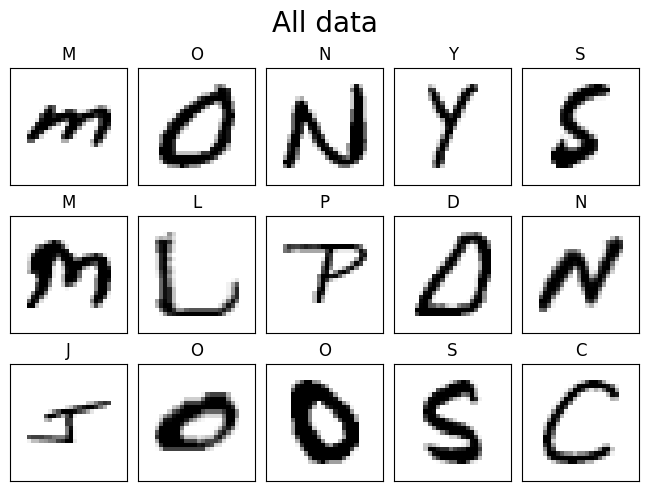

In [8]:
plot_images(X, y_decoded, nrows=3, ncols=5)

<Axes: ylabel='Count'>

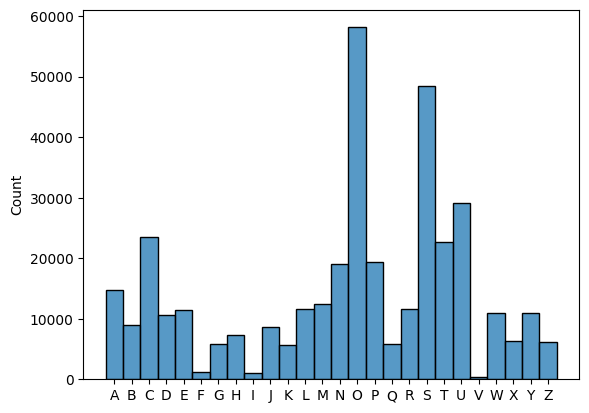

In [9]:
sns.histplot(y_decoded.flat)

### Split data into train, valid & test

In [10]:
# OneHotEncoder
y = tf.keras.utils.to_categorical(y)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_dummy, y_train, y_dummy = train_test_split(X, y,
                                                      test_size=0.2,
                                                      shuffle=True, random_state=42,
                                                      stratify=y
                                                      )

X_valid, X_test, y_valid, y_test = train_test_split(X_dummy, y_dummy,
                                                    test_size=0.5,
                                                    shuffle=True, random_state=42,
                                                    stratify=y_dummy
                                                    )

In [12]:
print(f"Train features shape = {X_train.shape}, target shape = {y_train.shape}")
print(f"Valid features shape = {X_valid.shape}, target shape = {y_valid.shape}")
print(f"Test features shape = {X_test.shape}, target shape = {y_test.shape}")

Train features shape = (297629, 28, 28, 1), target shape = (297629, 26)

Valid features shape = (37204, 28, 28, 1), target shape = (37204, 26)

Test features shape = (37204, 28, 28, 1), target shape = (37204, 26)


#### Image data generator

In [13]:
batch_size = 32

train_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow(
    X_train, y_train,
    batch_size=batch_size
)

validation_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow(
    X_valid, y_valid,
    batch_size=batch_size
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow(
    X_test, y_test,
    batch_size=batch_size
)

## **Modeling**

### Basic CNN Model

In [14]:
NAME = f"handwritten-az-basic-cnn-{int(time.time())}"

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"../working/logs/{NAME}")

In [15]:
basic_cnn = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(IMAGE_SHAPE),
        
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(ASCII_UPPERCASE.shape[0], activation='softmax')        
    ],
    name=NAME
)

basic_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

basic_cnn.summary()

Model: "handwritten-az-basic-cnn-1717257674"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 26, 26, 32)        320       

                                                                 

 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         

 )                                                               

                                                                 

 flatten (Flatten)           (None, 5408)              0         

                                                                 

 dense (Dense)               (None, 26)                140634    

                                                                 


Total params: 140,954

Trainable params: 140,954

Non-trainable params: 0

_________________________________________________________________


In [16]:
history_basic_cnn = basic_cnn.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[tensorboard]
)

Epoch 1/10

9301/9301 [==============================] - 35s 3ms/step - loss: 0.3489 - accuracy: 0.9382 - val_loss: 0.1592 - val_accuracy: 0.9590

Epoch 2/10

9301/9301 [==============================] - 30s 3ms/step - loss: 0.1457 - accuracy: 0.9612 - val_loss: 0.1568 - val_accuracy: 0.9599

Epoch 3/10

9301/9301 [==============================] - 31s 3ms/step - loss: 0.1299 - accuracy: 0.9657 - val_loss: 0.1360 - val_accuracy: 0.9661

Epoch 4/10

9301/9301 [==============================] - 32s 3ms/step - loss: 0.1200 - accuracy: 0.9683 - val_loss: 0.1483 - val_accuracy: 0.9663

Epoch 5/10

9301/9301 [==============================] - 32s 3ms/step - loss: 0.1137 - accuracy: 0.9699 - val_loss: 0.1555 - val_accuracy: 0.9625

Epoch 6/10

9301/9301 [==============================] - 32s 3ms/step - loss: 0.1066 - accuracy: 0.9716 - val_loss: 0.1619 - val_accuracy: 0.9653

Epoch 7/10

9301/9301 [==============================] - 32s 3ms/step - loss: 0.1054 - accuracy: 0.9726 - val_loss: 0.

### Evaluation

In [17]:
def onehot_decode(arr):
    return ASCII_UPPERCASE[np.argmax(arr, axis=1)]

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_comfusion_matrix(y_valid, y_valid_pred, y_test, y_test_pred):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    cmd_valid = ConfusionMatrixDisplay.from_predictions(
        onehot_decode(y_valid), onehot_decode(y_valid_pred),
        ax=axs[0]
    )
    customize_comfusion_matrix(cmd_valid)
    axs[0].set_title('Validation data')

    cmd_test = ConfusionMatrixDisplay.from_predictions(
        onehot_decode(y_test), onehot_decode(y_test_pred),
        ax=axs[1]
    )
    customize_comfusion_matrix(cmd_test)
    axs[1].set_title('Test data')

    fig.show()

def customize_comfusion_matrix(cmd):
    for text in cmd.text_.ravel():
        if text.get_text() == '0':
            text.set_text('')

        text.set_fontsize(5)

In [19]:
from sklearn.metrics import classification_report

def print_classification_report(y_valid, y_valid_pred, y_test, y_test_pred):
    rep_valid = classification_report(onehot_decode(y_valid), onehot_decode(y_valid_pred))
    print("Validation data report:")
    print(rep_valid)

    print("\n"*4)

    rep_test = classification_report(onehot_decode(y_test), onehot_decode(y_test_pred))
    print("Test data report:")
    print(rep_test)

In [20]:
def evaluate_model(y_valid, y_valid_pred, y_test, y_test_pred):
    plot_comfusion_matrix(y_valid, y_valid_pred, y_test, y_test_pred)
    print_classification_report(y_valid, y_valid_pred, y_test, y_test_pred)

1163/1163 [==============================] - 2s 1ms/step

1163/1163 [==============================] - 2s 1ms/step

Validation data report:

              precision    recall  f1-score   support



           A       0.97      0.96      0.96      1478

           B       0.96      0.95      0.95       897

           C       0.98      0.97      0.97      2356

           D       0.90      0.90      0.90      1060

           E       0.98      0.96      0.97      1149

           F       0.97      0.98      0.97       117

           G       0.93      0.96      0.95       579

           H       0.95      0.93      0.94       727

           I       0.96      0.96      0.96       112

           J       0.96      0.94      0.95       862

           K       0.92      0.94      0.93       562

           L       0.96      0.98      0.97      1164

           M       0.95      0.98      0.97      1245

           N       0.96      0.96      0.96      1909

           O       0.98      0.9

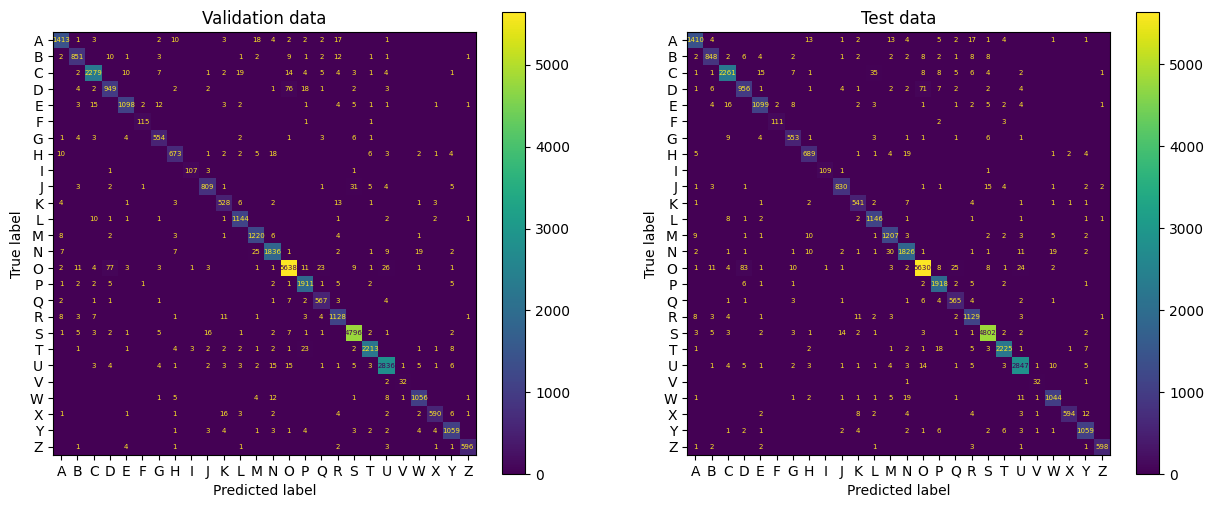

In [21]:
y_valid_pred = basic_cnn.predict(X_valid)
y_test_pred = basic_cnn.predict(X_test)

evaluate_model(y_valid, y_valid_pred, y_test, y_test_pred)

Модель показує більше ніж гарні результати. Розгляд складнішої архітектури та підбір гіперпараметрів мають сімнівний сенс, розглянемо це все на наступному *dataset*-і.

Для гарного завершення, нижче наведені криві навчання з ***Tensorboard*** (Графіки не з поточного навчання - одного з попередніх. Проте картина +- та ж).
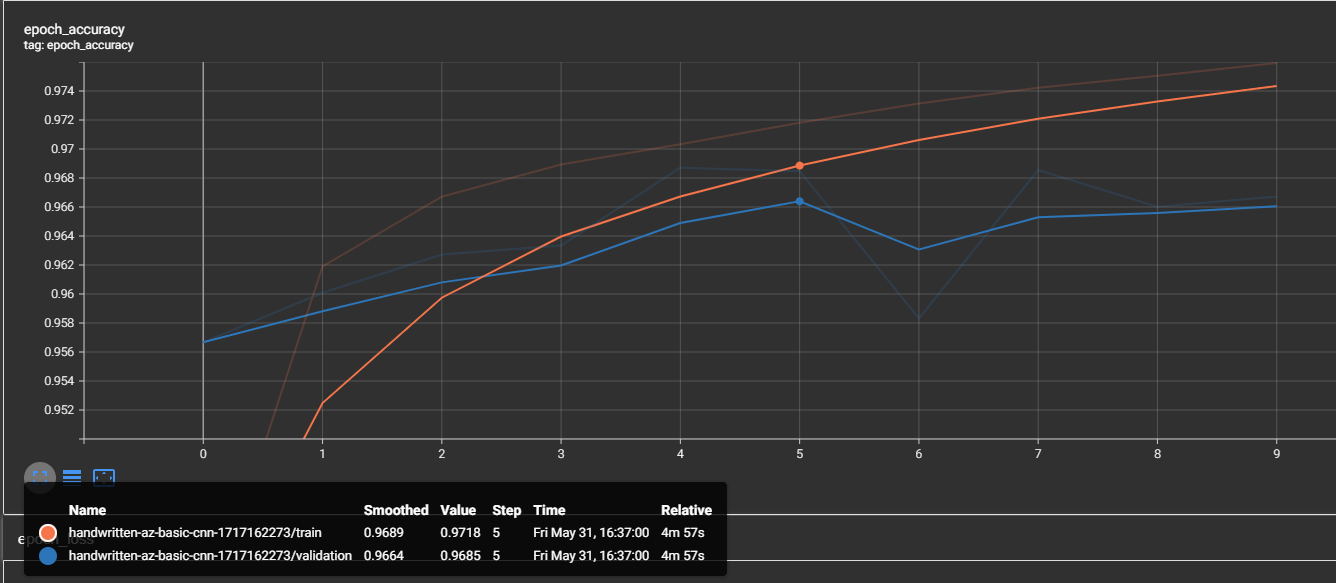
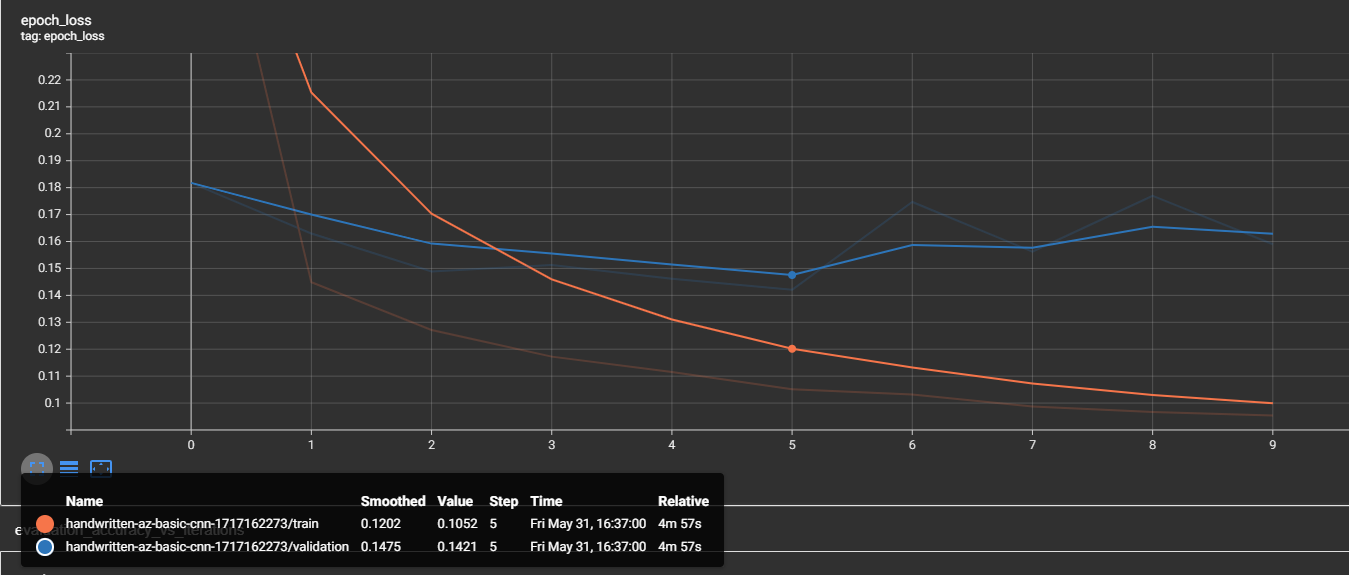

Покращення генералізації не відбувалося починаючи з 5 епохи.

### MLP Model

In [22]:
X = X.reshape(-1, IMAGE_SHAPE[0]*IMAGE_SHAPE[1])

print(f'X_shape={X.shape}, y_shape={y.shape}')

X_shape=(372037, 784), y_shape=(372037, 26)


In [23]:
NAME = f"handwritten-az-mlp-{int(time.time())}"

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"../working/logs/{NAME}")

In [24]:
mlp = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(IMAGE_SHAPE),
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),

        tf.keras.layers.Dense(ASCII_UPPERCASE.shape[0], activation='softmax')        
    ],
    name=NAME
)

mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp.summary()

Model: "handwritten-az-mlp-1717258001"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 flatten_1 (Flatten)         (None, 784)               0         

                                                                 

 dense_1 (Dense)             (None, 200)               157000    

                                                                 

 dense_2 (Dense)             (None, 100)               20100     

                                                                 

 dense_3 (Dense)             (None, 26)                2626      

                                                                 


Total params: 179,726

Trainable params: 179,726

Non-trainable params: 0

_________________________________________________________________


In [25]:
history_mlp = mlp.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[tensorboard]
)

Epoch 1/10

9301/9301 [==============================] - 37s 4ms/step - loss: 0.8388 - accuracy: 0.8388 - val_loss: 0.3257 - val_accuracy: 0.9181

Epoch 2/10

9301/9301 [==============================] - 32s 3ms/step - loss: 0.2960 - accuracy: 0.9245 - val_loss: 0.2643 - val_accuracy: 0.9363

Epoch 3/10

9301/9301 [==============================] - 31s 3ms/step - loss: 0.2560 - accuracy: 0.9365 - val_loss: 0.2475 - val_accuracy: 0.9399

Epoch 4/10

9301/9301 [==============================] - 36s 4ms/step - loss: 0.2429 - accuracy: 0.9415 - val_loss: 0.2196 - val_accuracy: 0.9479

Epoch 5/10

9301/9301 [==============================] - 38s 4ms/step - loss: 0.2321 - accuracy: 0.9443 - val_loss: 0.2448 - val_accuracy: 0.9422

Epoch 6/10

9301/9301 [==============================] - 36s 4ms/step - loss: 0.2293 - accuracy: 0.9459 - val_loss: 0.2549 - val_accuracy: 0.9412

Epoch 7/10

9301/9301 [==============================] - 37s 4ms/step - loss: 0.2261 - accuracy: 0.9475 - val_loss: 0.

### Evaluation

1163/1163 [==============================] - 2s 1ms/step

1163/1163 [==============================] - 2s 1ms/step

Validation data report:

              precision    recall  f1-score   support



           A       0.92      0.96      0.94      1478

           B       0.81      0.92      0.86       897

           C       0.90      0.97      0.93      2356

           D       0.91      0.87      0.89      1060

           E       0.90      0.94      0.92      1149

           F       0.88      0.90      0.89       117

           G       0.97      0.90      0.93       579

           H       0.93      0.87      0.90       727

           I       0.97      0.76      0.85       112

           J       0.75      0.92      0.82       862

           K       0.96      0.74      0.84       562

           L       0.91      0.98      0.94      1164

           M       0.98      0.94      0.96      1245

           N       0.95      0.92      0.94      1909

           O       0.98      0.9

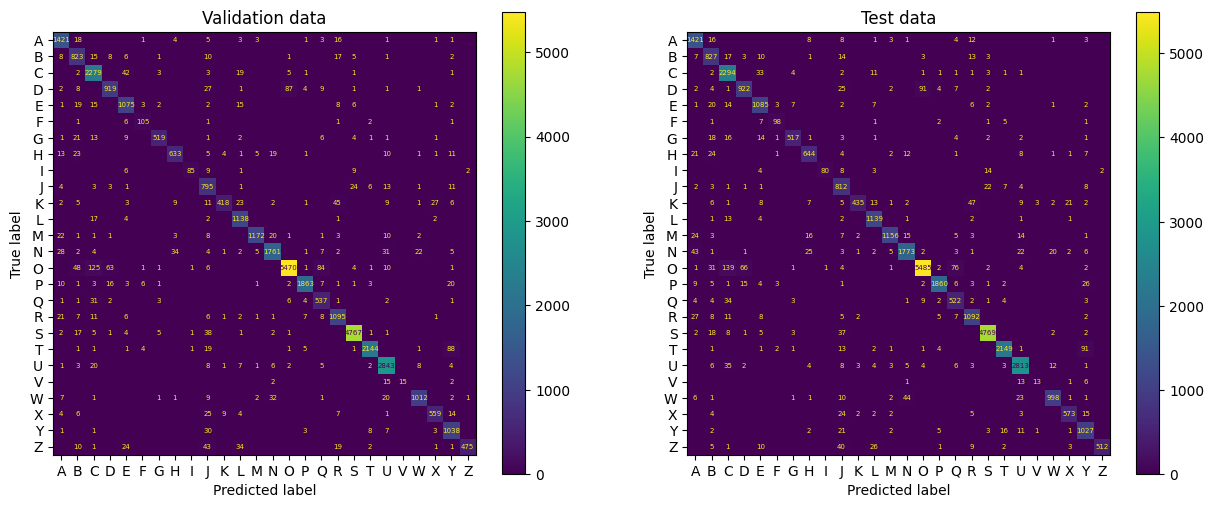

In [26]:
y_valid_pred = mlp.predict(X_valid)
y_test_pred = mlp.predict(X_test)

evaluate_model(y_valid, y_valid_pred, y_test, y_test_pred)

Маємо трохи гірші результати (за рахунок другого скритого шару, без нього точність близько 88). Який можна зробити висновок, набір даних достатньо простий як для згорткових мереж, цікавіші результати можна буда спостерігати на кольоровому наборі.